# Spark configuration 

Guided by this <a href="https://www.analyticsvidhya.com/blog/2020/11/a-must-read-guide-on-how-to-work-with-pyspark-on-google-colab-for-data-scientists/"> link </a>

# Java jdk installaion

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

**Apache Spark 3.2.1 with Hadoop 3.2 installation**

In [ ]:
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz


**Installing findspark library to get spark instance**

In [ ]:
!pip install -q findspark

**Setting environment paths for java and spark**

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

**Importing findspark and initializing it and then testing to find spark instance**

In [ ]:
import findspark
findspark.init()

In [ ]:
findspark.find()

'/content/spark-3.2.1-bin-hadoop3.2'

**Creatig spark instance**

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BDC_PROJECT").master("local[*]").getOrCreate()
spark

**Downloading NSL-KDD dataset and inflating it**

In [ ]:
!wget -q http://205.174.165.80/CICDataset/NSL-KDD/Dataset/NSL-KDD.zip

In [ ]:
!unzip NSL-KDD.zip

Archive:  NSL-KDD.zip
  inflating: index.html              
  inflating: KDDTest1.jpg            
  inflating: KDDTest-21.arff         
  inflating: KDDTest-21.txt          
  inflating: KDDTest+.arff           
  inflating: KDDTest+.txt            
  inflating: KDDTrain1.jpg           
  inflating: KDDTrain+.arff          
  inflating: KDDTrain+.txt           
  inflating: KDDTrain+_20Percent.arff  
  inflating: KDDTrain+_20Percent.txt  


**Feature names**

In [ ]:
features=["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","class", "class_nmbr"]

In [ ]:
discrete_features = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'root_shell',
                    'su_attempted', 'is_host_login','is_guest_login']

**Features that have categorical string values**

In [ ]:
categorical_cols = ['protocol_type', 'service', 'flag','class']

In [ ]:
path_to_train = "/content/KDDTrain+.txt"
path_to_test = "/content/KDDTest+.txt"

In [ ]:
train_df = spark.read.options(delimiter=",", header=False, inferSchema=True).csv(path_to_train).toDF(*features)
test_df = spark.read.options(delimiter=",", header=False, inferSchema=True).csv(path_to_test).toDF(*features)

In [ ]:
train_df.show(5)

+--------+-------------+--------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+----------+
|duration|protocol_type| service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host

**Droping redundant column "class_nmbr" from dataframe, it has almost the same as "class" column**

In [ ]:
train_df = train_df.drop(train_df["class_nmbr"])
test_df = test_df.drop(test_df["class_nmbr"])

**Casting columns with int dtype to double in order to be able to process them**

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

for c, dtype in train_df.dtypes:
    if dtype == 'int':
        train_df = train_df.withColumn(c,col(c).cast(DoubleType()))
from pyspark.sql.functions import col
for c, dtype in test_df.dtypes:
    if dtype == 'int':
        test_df = test_df.withColumn(c,col(c).cast(DoubleType()))

**Schema of dataframes**

In [ ]:
train_df.printSchema() 

root
 |-- duration: double (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: double (nullable = true)
 |-- dst_bytes: double (nullable = true)
 |-- land: double (nullable = true)
 |-- wrong_fragment: double (nullable = true)
 |-- urgent: double (nullable = true)
 |-- hot: double (nullable = true)
 |-- num_failed_logins: double (nullable = true)
 |-- logged_in: double (nullable = true)
 |-- num_compromised: double (nullable = true)
 |-- root_shell: double (nullable = true)
 |-- su_attempted: double (nullable = true)
 |-- num_root: double (nullable = true)
 |-- num_file_creations: double (nullable = true)
 |-- num_shells: double (nullable = true)
 |-- num_access_files: double (nullable = true)
 |-- num_outbound_cmds: double (nullable = true)
 |-- is_host_login: double (nullable = true)
 |-- is_guest_login: double (nullable = true)
 |-- count: double (nullable = true)
 |-- srv_count: do

**Droping rows with one or more missing value**

In [ ]:
train_df = train_df.na.drop()
test_df = test_df.na.drop()

In [ ]:
'number of training instances: {}, number of features: {}'.format(train_df.count(),len(train_df.columns))

'number of training instances: 125973, number of features: 42'

In [ ]:
'number of test instances: {}, number of features: {}'.format(test_df.count(),len(test_df.columns))

'number of test instances: 22544, number of features: 42'

In [ ]:
train_df = train_df.distinct()
test_df = test_df.distinct()

In [ ]:
'number of distinct training instances: {}'.format(train_df.count())

'number of distinct training instances: 125973'

In [ ]:
'number of distinct test instances: {}'.format(test_df.count())

'number of distinct test instances: 22544'

casting to pandas dataframe to run sns functions on it for plotting

In [ ]:
train_df_pd = train_df.toPandas()

importing seaborn and matplotlib to use for showing plots

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

seaborn plot configuration

In [ ]:
sns.set_style("darkgrid")
sns.set_context("notebook", rc={"lines.linewidth": 2, 
                                "xtick.labelsize":14, 
                                "ytick.labelsize":14,
                                "axes.labelsize": 18
                                })

Box plot for all non-categorical features

as we can see, there are some points that are far from boxes src_bytes and destination_bytes. although they might be outlires but the problem suggests that outliers must be attackers, therefore the best solution is **not** to remove this instances from data 

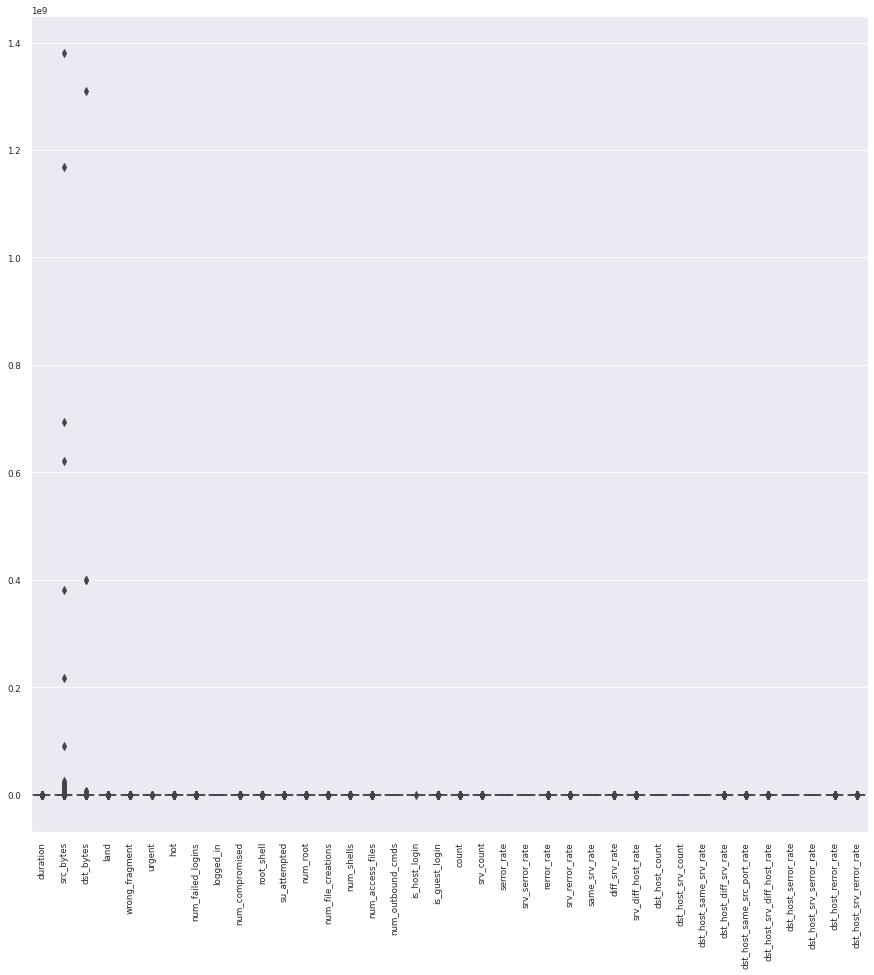

In [ ]:
plt.figure(figsize=(15,15))
sns.set(font_scale=0.8)
ax = sns.boxplot(data = train_df_pd.drop(['class'], axis = 1))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

describing data shows different distributions for different features. We can infer that the distribution for continous features must get standardized in order to have same range and distribuition parameters for all features

In [ ]:
train_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
duration,125973,287.1446500440571,2604.515309867588,0.0,42908.0
protocol_type,125973,None,None,icmp,udp
service,125973,None,None,IRC,whois
flag,125973,None,None,OTH,SH
src_bytes,125973,45566.74300048423,5870331.181893572,0.0,1.379963888E9
dst_bytes,125973,19779.114421344257,4021269.1514414283,0.0,1.309937401E9
land,125973,1.9845522453224102E-4,0.014086071671513054,0.0,1.0
wrong_fragment,125973,0.022687401268525795,0.2535299859520132,0.0,3.0
urgent,125973,1.1113492573805498E-4,0.014366026620154284,0.0,3.0


features to compute correlation on

In [ ]:
correlation_features = list(set(features[:-1]) - set(categorical_cols))

correlation matrix

correlation matrix shows some high correlation between features. One might get rid of features with high correlation but removing them will affect performance of any model because although some features have correlation but each has different valuable information within that might not be the causation of others

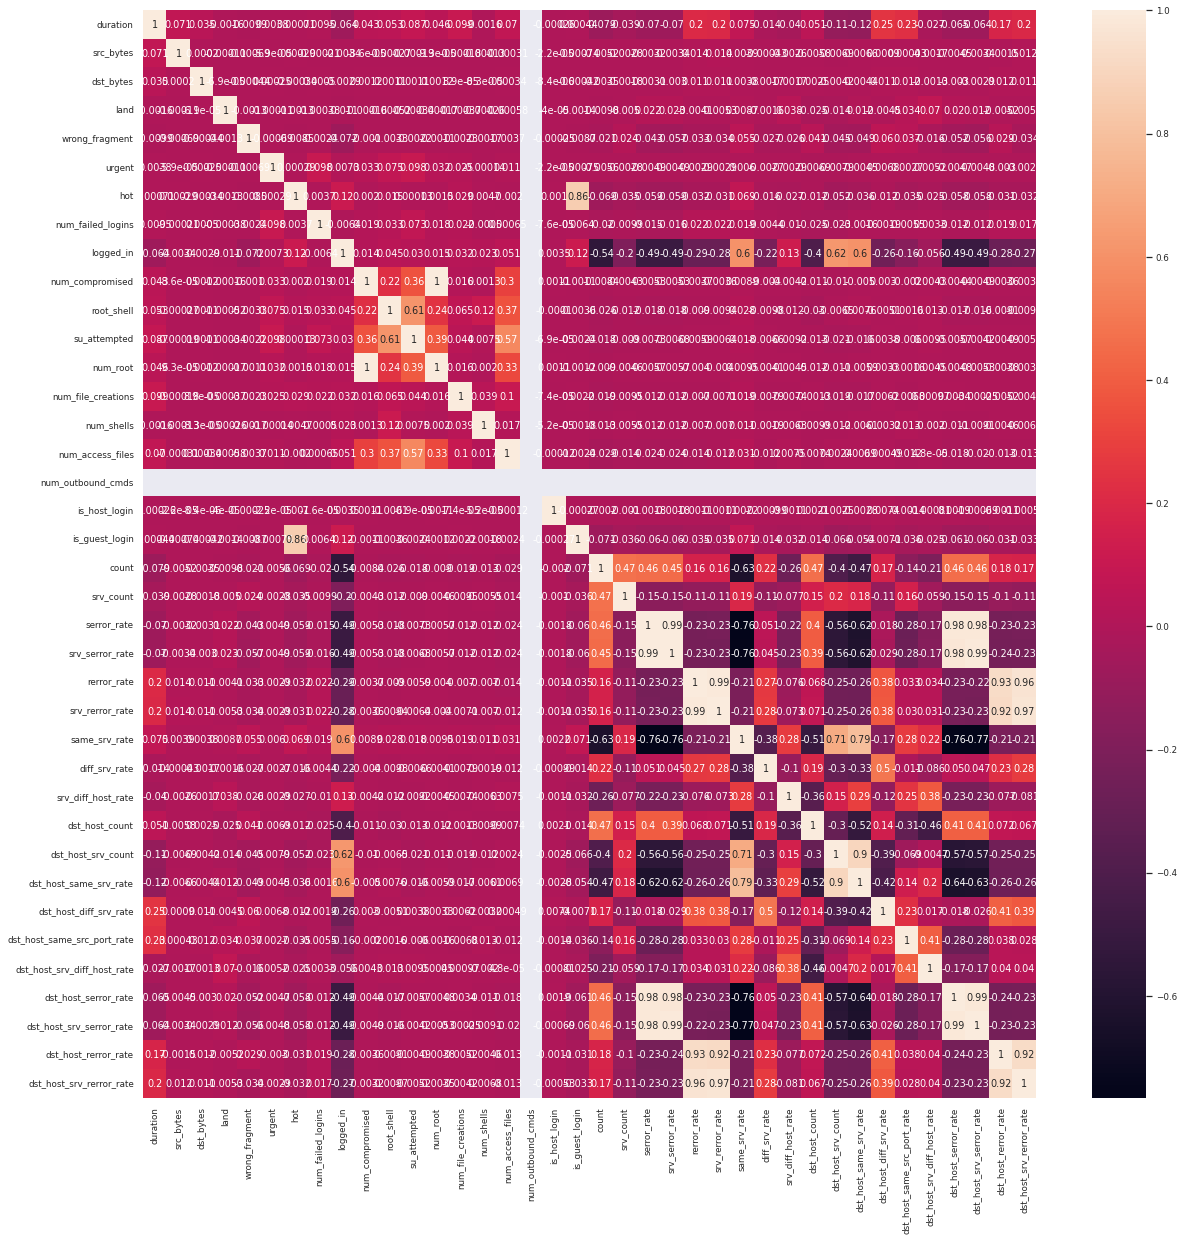

In [ ]:
Correlation_matrix = train_df_pd.corr()
plt.figure(figsize=(20,20))
sns.heatmap(Correlation_matrix, annot=True)
plt.show()

sample numbers

number of sample in each class shows high difference of sample numbers in different classes. This comes from rarity of attacks.
One might suggest balancing using undersampling or oversampling, but with this difference in numbers they are not effective. One good suggestion is to reduce category of attacks by their family.

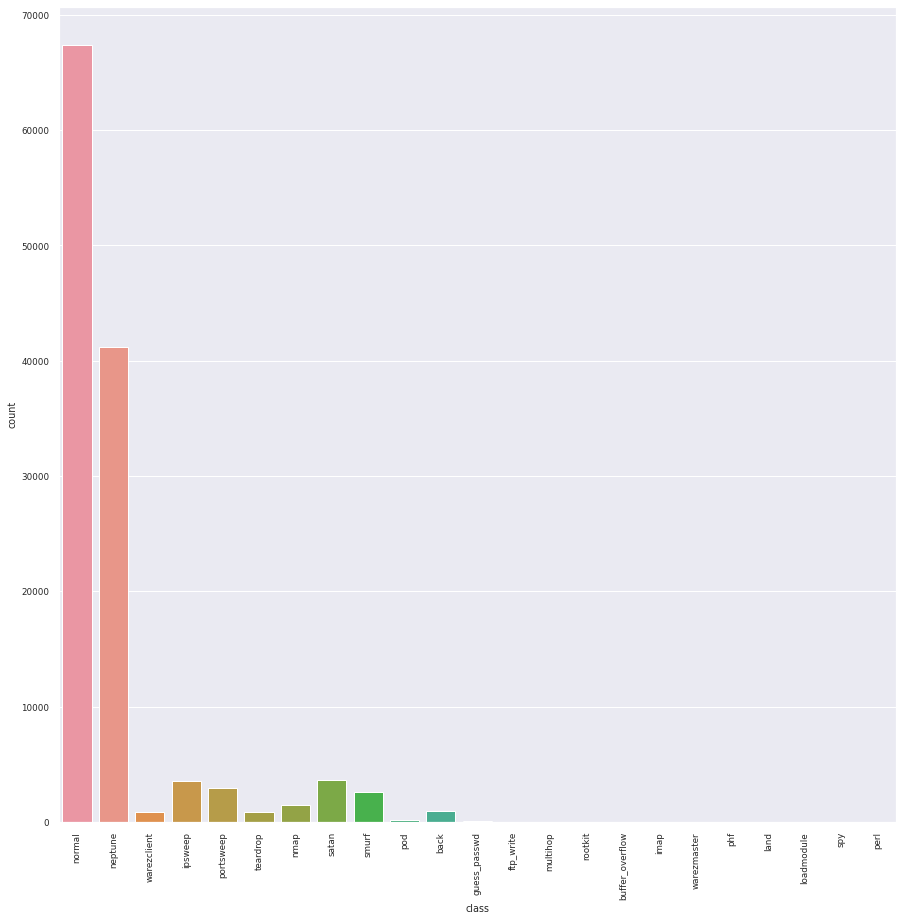

In [ ]:
plt.figure(figsize=(15, 15))
ax = sns.countplot(x='class',data= train_df_pd)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

distribution plots of features

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

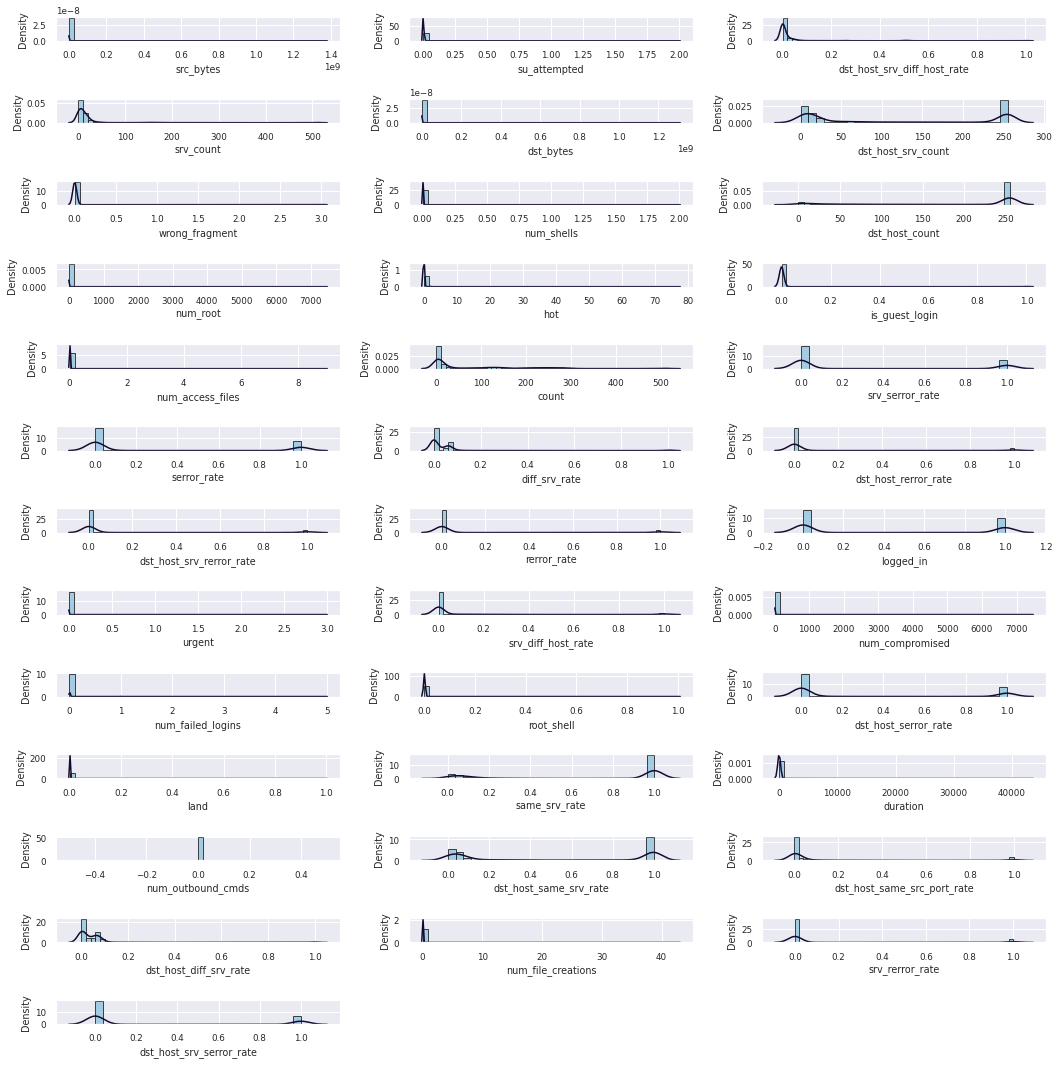

In [ ]:
fig, axes = plt.subplots(13,3, figsize=(15,15))
fig.delaxes(axes[12][2])
fig.delaxes(axes[12][1])
for i,f in enumerate(correlation_features):
    _ = sns.distplot(train_df_pd[f],
                   kde_kws={"color": "#130931", "lw": 1.5}, 
                   hist_kws={"histtype": "bar", "edgecolor": "k", "linewidth": 1,"alpha": 0.8, "color": "#92c5de"},
                   ax=axes[i//3, i%3])

fig.tight_layout(pad=1.5)

observation shows that some features have two distributions since they have two peeks. The simplest choice is to have the hypothesis that features have one distribution and it is gaussian distribution.

# Preproccessing

**Beggining the dataset cleaning and preprocess**

In [ ]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

**Dictionary to map classes to 5 general attack types**

Class transformations happen for two reasons. The first reason is that the number of some sample classes is small. The second reason is that a series of attacks take place over time. To predict future attacks, it is better to categorize them based on their family class because the approach to defense against them is usually similar.

In [ ]:
class_to_5 = {}
for c in ['apache2', 'Smurf', 'Neptune', 'Back', 'Teardrop', 'Pod', 'Land', 'Mailbomb', 'Processtable', 'UDPstorm']:
    class_to_5[c.lower()] = 'dos'
    
for c in ['Satan', 'Saint', 'Ipsweep', 'Portsweep', 'Nmap', 'Mscan']:
    class_to_5[c.lower()] = 'probe'
    
for c in ['WarezClient', 'guess_passwd', 'WarezMaster',
          'Imap', 'Ftp_Write', 'Named', 'MultiHop',
          'Phf', 'Spy', 'Sendmail', 'SnmpGetAttack',
          'SnmpGuess', 'Worm', 'Xsnoop', 'Xlock']:
    class_to_5[c.lower()] = 'r2l'
    
for c in ['Buffer_Overflow', 'httptunnel', 'Rootkit', 'LoadModule', 'Perl', 'Xterm',
          'Ps', 'SQLattack']:
    class_to_5[c.lower()] = 'u2r'

class_to_5['normal'] = 'normal'

**Mapping classes to 5 general classes**

In [ ]:
train_df = train_df.withColumn("class", udf(lambda c : class_to_5[c],StringType())("class"))
test_df = test_df.withColumn("class", udf(lambda c : class_to_5[c],StringType())("class"))

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline

**Features that must get one hot encoded**

In [ ]:
categorical_cols = ['protocol_type', 'service', 'flag','class']

**Indexer for converting strings to indexes**

**Onehot encoder for converting discrete features to onehot encoded vectors**

**Standard scaler for converting distribution of continuous features to** 
**standard normal**

**At last creating a pipeline from all steps** 

In [ ]:
indexer = StringIndexer()
indexer.setInputCols(categorical_cols)
indexer.setOutputCols([col+'_idx' for col in categorical_cols])

ohe = OneHotEncoder()
ohe.setInputCols([(col if col not in categorical_cols else col +'_idx') for col in discrete_features])
ohe.setOutputCols([col +'_cat' for col in discrete_features])

vectorizers = [VectorAssembler(inputCols=[col], outputCol=('vec_' + col)) 
                            for col in features if col not in discrete_features + ['class', 'class_nmbr']]
standard_scalers = [StandardScaler(inputCol='vec_'+col, outputCol=col + "_standard") 
                            for col in features if col not in discrete_features + ['class', 'class_nmbr']]
feature_vectorizer = VectorAssembler(inputCols=[col +'_cat' if col in discrete_features else col + '_standard' for col in features[:-2]],
                             outputCol='features')
pipeline = Pipeline(stages=[indexer, ohe] + vectorizers + standard_scalers + [feature_vectorizer])

In [ ]:
all_data_df = train_df.union(test_df)
train_df = pipeline.fit(all_data_df).transform(train_df)
test_df = pipeline.fit(all_data_df).transform(test_df)

showing classes and their indexes

In [ ]:
train_df.select(['class', 'class_idx']).distinct().show()

+------+---------+
| class|class_idx|
+------+---------+
| probe|      2.0|
|   u2r|      4.0|
|   r2l|      3.0|
|   dos|      1.0|
|normal|      0.0|
+------+---------+



**Balancing dataset using sample weighting**

In [ ]:
import numpy as np

In [ ]:
weights = train_df.groupBy('class').count().select('*').toPandas().values.reshape(-1,2)
num_all = np.sum(weights[:,1].astype(float))
weight_dict = dict([(r[0],float(1-(r[1]/num_all))) for r in weights])

number of samples in each of 5 classes

In [ ]:
weights

array([['u2r', 52],
       ['normal', 67343],
       ['r2l', 995],
       ['probe', 11656],
       ['dos', 45927]], dtype=object)

creating weight column that has weight for each instance using this formula: $w_{c} = 1 - \frac{n_{c}}{n_{all}}$ where $n_c$ is number of instances in class $c$ and $n_{all}$ is number of all samples in training data
These weights are near one for classes with very low number of instances and lower for classes with higher numbers

In [ ]:
train_df = train_df.withColumn("weights", udf(lambda c : weight_dict[c],DoubleType())("class"))

In [ ]:
train_df.show(5)

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+------+-----------------+-----------+--------+---------+-----------------+---------------+--------------+-------------+-------------+--------------+----------------+-----------------+------------------+------------+-------------+-------------+------------------+----------+-------+---------------------+-------------------+------------+----------------------+--------------+--------------------

# ONE VS. REST SVM classifier

In [ ]:
from pyspark.ml.classification import LinearSVC, OneVsRest

since svm in spark is not fully implemented, hence we dont have access to non-linear kernerls such as rbf and polynomials, therefore we have to use linear binary svm classifier.
to use svm for multiclass data, we use OneVsRest classifier which will train 5 binary svms, each classifing one class from other ones.  

In [ ]:
svm = LinearSVC(labelCol='class_idx')
classifier = OneVsRest(classifier=svm, labelCol='class_idx')

In [ ]:
classifier = classifier.fit(train_df)

weighted svm to test wighting for balancing purposes

In [ ]:
LinearSVC(labelCol='class_idx', weightCol='weights')
balanced_classifier = OneVsRest(classifier=svm, labelCol='class_idx')
balanced_classifier = balanced_classifier.fit(train_df)

## Evaluation of SVM

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, plot_confusion_matrix

a function that will take classifier and data as input and evaluate it using accuracy, tor, fpr and confusion matrix

In [ ]:
def evaluate_model(classifier, data):
    labels_and_predictions = classifier.transform(data)
    labels_and_predictions = labels_and_predictions.select(['prediction', 'class_idx'])
    labels_and_predictions_rdd = labels_and_predictions.rdd.map(tuple)
    metrics = MulticlassMetrics(labels_and_predictions_rdd)
    print('true positive rates: ', [metrics.truePositiveRate(float(i)) for i in range(5)])
    print('false positive rates: ', [metrics.falsePositiveRate(float(i)) for i in range(5)])
    print('Accuracy: ', metrics.accuracy)
    cm = metrics.confusionMatrix().toArray()
    plt.figure(figsize=(10,10))
    cmdisplay = ConfusionMatrixDisplay(cm, display_labels=['0','1','2', '3','4'])
    cmdisplay.plot(values_format='.0f')
    plt.show()

**Unbalanced classifier evaluation**

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


true positive rates:  [0.9269900113273607, 0.8400375435773666, 0.6299049979347378, 0.006535947712418301, 0.075]
false positive rates:  [0.3579833242421881, 0.021543152591806974, 0.03463698255727277, 0.004800404244567963, 0.00035803795202291446]
Accuracy:  0.7463183108587651


<Figure size 720x720 with 0 Axes>

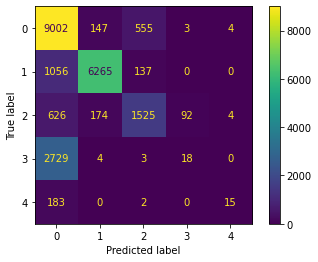

In [ ]:
evaluate_model(classifier, test_df)

**Balanced classifier evaluation**

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


true positive rates:  [0.9269900113273607, 0.8400375435773666, 0.6299049979347378, 0.006535947712418301, 0.075]
false positive rates:  [0.3579833242421881, 0.021543152591806974, 0.03463698255727277, 0.004800404244567963, 0.00035803795202291446]
Accuracy:  0.7463183108587651


<Figure size 720x720 with 0 Axes>

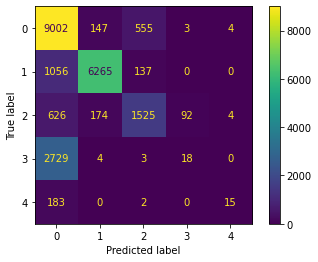

In [ ]:
evaluate_model(balanced_classifier, test_df)

as we can see weighting does not effect results
the best classified class is normal and the worst is dos
from the confusion matrix we can see the closeness of normal with attacks that make sense and cause model to predict wrong

since the random classiert for a 5 class problem have a chance of 20% guessing right, the 74.63% accuracy for a linear model is acceptable

also true positive and false positive rates are acceptable but suggest no reliablity on using model and it must get better


# Multilayer Perceptron

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

**We test 3 and 4 layers since pyspark mlp wont let us customize network and it will most likely cause overfitting and gradient vanishing for more layers**

In [ ]:
solvers = ["l-bfgs", "gd"]
layers = [[64,64,5], [64,64,64,5]]
inputs = [len(train_df.first().features.toArray())]

**Grid search on 2 solvers and 3,4 layers**
grid searching will ge us the best model with gd or bfgs solver and 3 or layers and the best will be compared to svm

In [ ]:
models = dict()
for solver in solvers:
    for layer in layers:
        model = MultilayerPerceptronClassifier(maxIter=50, layers=inputs+layer, solver=solver,
                                               blockSize=64, seed=1, labelCol="class_idx")
        model = model.fit(train_df)
        models['{}-layers-solver-{}'.format(len(layer), solver)] = model

evaluation of model:  3-layers-solver-l-bfgs


/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


true positive rates:  [0.936360827927093, 0.7945829981228212, 0.5695993391160677, 0.04357298474945534, 0.0]
false positive rates:  [0.40029611158731393, 0.03791594856158027, 0.015454952044923718, 0.0003031834259727135, 0.0]
Accuracy:  0.7327004968062456


<Figure size 720x720 with 0 Axes>

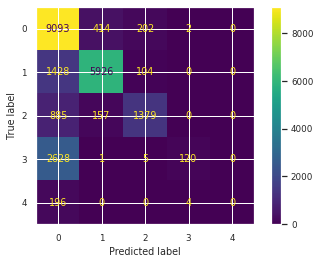

--------------------------------------------------
evaluation of model:  4-layers-solver-l-bfgs
true positive rates:  [0.9276078673669035, 0.7768838830785734, 0.6344485749690211, 0.006899055918663762, 0.0]
false positive rates:  [0.406530039741292, 0.04394803128728623, 0.014262286935347613, 0.001010611419909045, 0.0]
Accuracy:  0.7255589070262598


<Figure size 720x720 with 0 Axes>

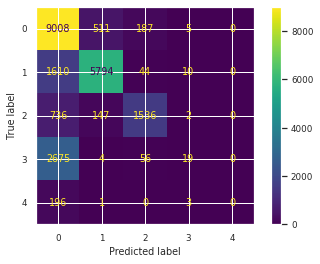

--------------------------------------------------
evaluation of model:  3-layers-solver-gd
true positive rates:  [1.0, 0.0, 0.0, 0.0, 0.0]
false positive rates:  [1.0, 0.0, 0.0, 0.0, 0.0]
Accuracy:  0.43075762952448543


<Figure size 720x720 with 0 Axes>

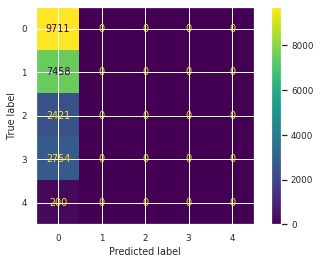

--------------------------------------------------
evaluation of model:  4-layers-solver-gd
true positive rates:  [1.0, 0.0, 0.0, 0.0, 0.0]
false positive rates:  [1.0, 0.0, 0.0, 0.0, 0.0]
Accuracy:  0.43075762952448543


<Figure size 720x720 with 0 Axes>

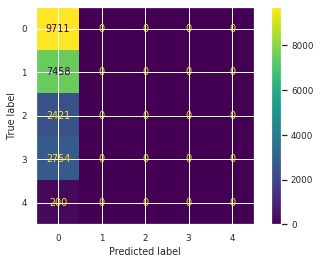

--------------------------------------------------


In [ ]:
for name, model in models.items():
    print("evaluation of model: ", name)
    evaluate_model(model, test_df)
    print("-"*50)

as we can see for mlp models, gradiant descent algorithm can not get good results for our models and we suggest that it will stay in a local minima. on the other hand, the bfgs solver with 3 layers gives the best scores that will suggest overfitting in 4 layers with same solver.
In conclusion, the svm worked better than mlp so far

# Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
num_trees = [10, 20 , 30]
max_depths = [3,4,5]

**Grid search on 10, 20, 30 random forrests and 3,4,5 max depths**

grid search will train models with 10, 20 and 30 trees alongside maximum depths of 3, 4, and 5 levels, then all the 9 models will be evaluated and best of them will be compared to svm and mlp

In [ ]:
random_forests = dict()
for num_tree in num_trees:
    for max_depth in max_depths:
        random_forrest = RandomForestClassifier(numTrees=num_tree, maxDepth=max_depth,
                                                featuresCol="features", labelCol="class_idx", seed=1)
        random_forrest = random_forrest.fit(train_df)
        random_forests['{}-tree-{}-max depth'.format(num_tree, max_depth)] = random_forrest

evaluation of model:  10-tree-3-max depth


/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


true positive rates:  [0.99557203171661, 0.6252346473585412, 0.004956629491945477, 0.0, 0.0]
false positive rates:  [0.5483519052442921, 0.07715762959034866, 0.0, 0.0, 0.0]
Accuracy:  0.636222498225692


<Figure size 720x720 with 0 Axes>

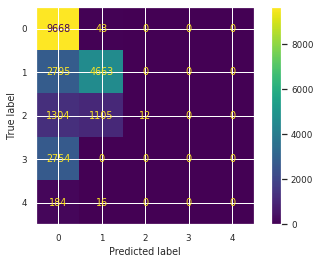

--------------------------------------------------
evaluation of model:  10-tree-4-max depth
true positive rates:  [0.9810524147873545, 0.7003218020917136, 0.2845931433292028, 0.0, 0.0]
false positive rates:  [0.45686900958466453, 0.06337001193159221, 0.014212592555781941, 0.0, 0.0]
Accuracy:  0.6848385379701917


<Figure size 720x720 with 0 Axes>

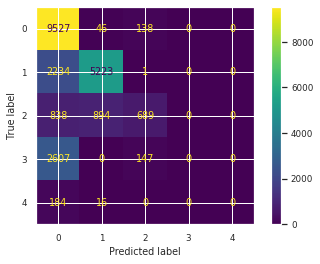

--------------------------------------------------
evaluation of model:  10-tree-5-max depth
true positive rates:  [0.9781690866028215, 0.7144006436041834, 0.5625774473358116, 0.0, 0.0]
false positive rates:  [0.44190758201511726, 0.02969640726501392, 0.011727873577498386, 0.0, 0.0]
Accuracy:  0.7181068133427964


<Figure size 720x720 with 0 Axes>

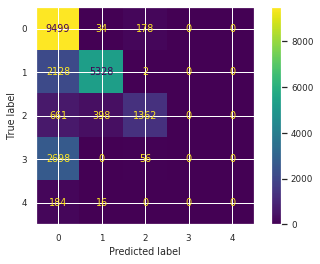

--------------------------------------------------
evaluation of model:  20-tree-3-max depth
true positive rates:  [0.9938214396045721, 0.6432019308125503, 0.107393638992152, 0.0, 0.0]
false positive rates:  [0.5303514376996805, 0.06569004374917142, 0.0019380808030611738, 0.0, 0.0]
Accuracy:  0.6524130589070263


<Figure size 720x720 with 0 Axes>

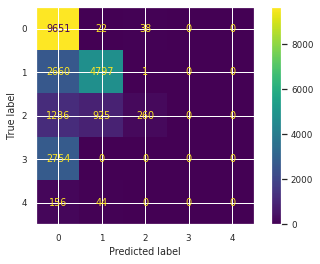

--------------------------------------------------
evaluation of model:  20-tree-4-max depth
true positive rates:  [0.9816702708268973, 0.6505765620809869, 0.5444031391986782, 0.0, 0.0]
false positive rates:  [0.4980908595028442, 0.017764815060320828, 0.008994682701386474, 0.0, 0.0]
Accuracy:  0.6965489709013485


<Figure size 720x720 with 0 Axes>

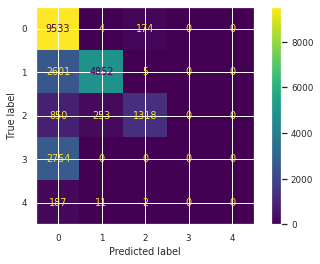

--------------------------------------------------
evaluation of model:  20-tree-5-max depth
true positive rates:  [0.9783750386160025, 0.7322338428533118, 0.5807517554729451, 0.0, 0.0]
false positive rates:  [0.44447907737863324, 0.0185602545406337, 0.009541320876608856, 0.0, 0.0]
Accuracy:  0.7260468417317246


<Figure size 720x720 with 0 Axes>

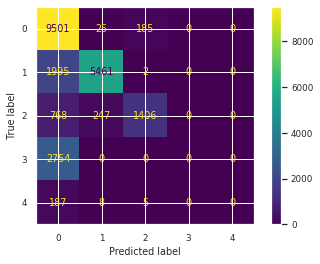

--------------------------------------------------
evaluation of model:  30-tree-3-max depth
true positive rates:  [0.995777983729791, 0.6238938053097345, 0.12267657992565056, 0.0, 0.0]
false positive rates:  [0.5437543832307332, 0.060784833620575365, 0.0014411370074044626, 0.0, 0.0]
Accuracy:  0.6485095812633073


<Figure size 720x720 with 0 Axes>

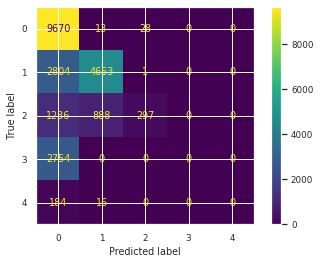

--------------------------------------------------
evaluation of model:  30-tree-4-max depth
true positive rates:  [0.9921738234991248, 0.6537945829981229, 0.44981412639405205, 0.0, 0.0]
false positive rates:  [0.5076755240395855, 0.02412833090282381, 0.003230134671768623, 0.0, 0.0]
Accuracy:  0.6919801277501775


<Figure size 720x720 with 0 Axes>

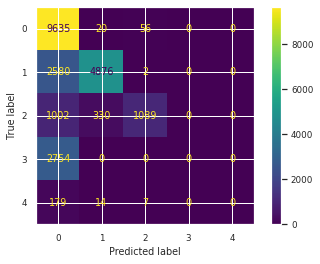

--------------------------------------------------
evaluation of model:  30-tree-5-max depth
true positive rates:  [0.9794047986819071, 0.6792705819254492, 0.5262288310615448, 0.0, 0.0]
false positive rates:  [0.4811813293851788, 0.022736311812276283, 0.008696516423992447, 0.0, 0.0]
Accuracy:  0.7031139105748758


<Figure size 720x720 with 0 Axes>

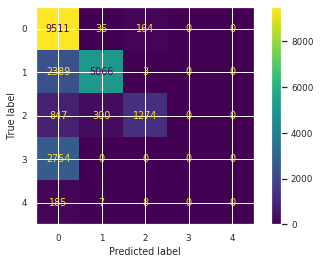

--------------------------------------------------


In [ ]:
for name, random_forrest in random_forests.items():
    print("evaluation of model: ", name)
    evaluate_model(random_forrest, test_df)
    print("-"*50)

 after a grid search on 9 random forests with different number of trees and max depths, we see that a random forest with 20 trees and max depth of 5 have a better performance on data with accuracy of 72.60% among all random forests.
 Furthermore we can see that re unreliablity of models shows itself in the fpr and tpr metrics alongside a confusion matrix that is similar to previous ones of the other models.

 In comparision to the previous svm and mlp models, random forest can not perform better and svm is still the best model among other ones.


# Conclusion

From analysis of data and evaluation of models on the same data, we can infer that these data have some problems. 
The main problem with the dataset is closeness of normal and attack request in a way that is hard to seperate and classify them. furthermore because of rarity of some attacks, there are not much samples from them and makes it hard to classify each attack family.

In a pasimistic attitude, the models are not reliable enough to use them in realtime systems because they can cause annoying intteruptions for normal users and they must get better for such usage.


In an optimistic attitude, the accuracies and other metrics are far better than random guess and are promissing for a better results.

As we saw in this project, different models in the KDD dataset which contains request data with different attacks and normal labels will do an acceptable classification bot yet not so powerful for real time systematic uses. Among all models One vs. All svm did better and had a better performance. Reliability of models were also checked by tpr and fpr metrics and shows that models are not much reliable when detecting attacks data.

In the future, one can use some technicues like auto encoding and matrix decompositions to get better features for each instance that are far better linearly separable.


# Resources

- https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html
- https://spark.apache.org/docs/2.2.0/ml-classification-regression.html
- https://stackoverflow.com/questions/33372838/dealing-with-unbalanced-datasets-in-spark-mllib

- https://www.researchgate.net/publication/323867082